In [1]:
import librosa, librosa.display
import numpy as np
from pydub import AudioSegment
import my_utils
import matplotlib.pyplot as plt

C:\Users\Lenovo\Anaconda3\envs\machine-learning\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [4]:
def split_entire_audio(female, male, mix):
    
    n_fft = 1024
    hop_length = 8
    sr = 16000
    
    # compute stft for both audio files -> works better when calling librosa.mono -> forces the audio signal to go down to mono
    stft_1 = librosa.stft(librosa.to_mono(female), window='hann', n_fft=n_fft, hop_length=hop_length)    
    stft_2 = librosa.stft(librosa.to_mono(male), window='hann', n_fft=n_fft, hop_length=hop_length)    
    stft_mix = librosa.stft(librosa.to_mono(mix), window='hann', n_fft=n_fft, hop_length=hop_length)

    
    # get mask for entire audio
    mask_1 = my_utils.compute_mask(stft_1, stft_2)
    mask_2 = 1 - mask_1
    print(mask_1[:, 44:])

#     mask_1 = librosa.util.softmask(np.abs(stft_1), np.abs(stft_2))
#     mask_2 = librosa.util.softmask(np.abs(stft_2), np.abs(stft_1))
    
    first_sound_stft = my_utils.get_stft_matrix_from_mixture(mask_1, stft_mix)
    second_sound_stft = my_utils.get_stft_matrix_from_mixture(mask_2, stft_mix)

    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_mix), ref=np.max),
                             y_axis='log', sr=sr)
    plt.title('Spectrograma sunet mixat')
    plt.colorbar()

    plt.subplot(3, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_1), ref=np.max),
                             y_axis='log', sr=sr)
    plt.title('Spectrograma voce1 din mix')
    plt.colorbar()
    plt.subplot(3, 1, 3)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(np.abs(stft_2)), ref=np.max),
                             y_axis='log', x_axis='time', sr=sr)
    plt.title('Spectrograma voce2 din mix')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    inverse_sound1_stft = librosa.istft(first_sound_stft, hop_length=hop_length, window='hann')
    inverse_sound2_stft = librosa.istft(second_sound_stft, hop_length=hop_length, window='hann')
#     print(inverse_sound1_stft[:10])
    
    librosa.output.write_wav("recordings/recover-full-female-2.wav", inverse_sound1_stft, sr = 16000)
    librosa.output.write_wav("recordings/recover-full-male-2.wav", inverse_sound2_stft, sr = 16000)

In [5]:
def split_audio_using_small_segments(female_filename, male_filename):    
    
    n_fft = 1024
    hop_length = 8
    mix_filename= my_utils.mix_audios(male_filename, female_filename)
    
    male = AudioSegment.from_wav(male_filename)
    female = AudioSegment.from_wav(female_filename)
    mix = AudioSegment.from_wav(mix_filename)

    sound1 = np.empty([0,])
    sound2 = np.empty([0,])
    sound = np.empty([0,])
    
    total_ms = mix.__len__()
    frame_size_ms = 10
    i = 0
    
    while i * frame_size_ms < total_ms:
        start = i * frame_size_ms
        stop = i * frame_size_ms + frame_size_ms
        
        # use the hop size at 50% of the frame size: for fs = 500, 0->500; 250->750; 500->1000...
#         start = i * (frame_size_ms / 2)
#         stop = i * (frame_size_ms / 2) + frame_size_ms
        
        # in case the frame size goes above mix length
        if stop > total_ms:
            fs = total_ms - start
            stop = i * frame_size_ms + fs
            
        # get frames from all audio signals, type = audiosegment
        frame_1 = my_utils.get_specific_frame_in_ms(female, start, stop)
        frame_2 = my_utils.get_specific_frame_in_ms(male, start, stop)
        frame_mix = my_utils.get_specific_frame_in_ms(mix,start, stop)


        # from audio segment convert to ndarray how librosa uses
        frame_1, r = my_utils.audiosegment_to_ndarray(frame_1)
        print('time length: %f seconds' % (len(frame_1)/r))
        print(len(frame_1))
        frame_2, r = my_utils.audiosegment_to_ndarray(frame_2)
        frame_mix, r = my_utils.audiosegment_to_ndarray(frame_mix)
        
#         print("length of ndarray of frame ",frame_1.shape)

        frame_1, frame_mix = my_utils.make_wav_files_same_size(frame_1, frame_mix)
        frame_2, frame_mix = my_utils.make_wav_files_same_size(frame_2, frame_mix)
#         print("duration window: ",librosa.get_duration(y=frame_1, sr=16000))
        print(librosa.stft(frame_1).shape)
        # compute the stft for each of them
        frame_1_stft = librosa.stft(librosa.to_mono(frame_1), window='hann', n_fft=n_fft, hop_length=hop_length)
        frame_2_stft = librosa.stft(librosa.to_mono(frame_2), window='hann', n_fft=n_fft, hop_length=hop_length)
        frame_mix_stft = librosa.stft(librosa.to_mono(frame_mix), window='hann', n_fft=n_fft, hop_length=hop_length)
        print("aici: ",frame_1_stft.shape, frame_1.shape)
#         inverse_sound1_stft = librosa.istft(frame_1_stft, hop_length=hop_length, window='hann')
#         inverse_sound2_stft = librosa.istft(frame_2_stft, hop_length=hop_length, window='hann')
        
        # compute masks for current frame
        mask_1 = my_utils.compute_mask(frame_1_stft, frame_2_stft)
        if i == 0:
            print(mask_1)
        mask_2 = my_utils.compute_mask(frame_2_stft, frame_1_stft)
        
#         mask_1 = librosa.util.softmask(np.abs(frame_1_stft), np.abs(frame_2_stft), power=1000)
#         mask_2 = librosa.util.softmask(np.abs(frame_2_stft), np.abs(frame_1_stft), power=1000)

        # get sound for each source of i-th frame
        y_frame_1_stft_with_mask = mask_1 * frame_mix_stft
        y_frame_2_stft_with_mask = mask_2 * frame_mix_stft
        
        inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
        inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

#         inverse_sound_mix_stft = librosa.istft(inv, hop_length=hop_length, window='hann')

        sound1 = np.concatenate((sound1, inverse_sound1_stft))
        sound2 = np.concatenate((sound2, inverse_sound2_stft))

        if i == 0:
            sr = 16000
            plt.figure(figsize=(12, 8))
            plt.subplot(3, 1, 1)
            librosa.display.specshow(librosa.amplitude_to_db(np.abs(frame_1_stft.transpose()), ref=np.max),
                                     y_axis='log', sr=sr)
            plt.title('female - original segment STFT')
            plt.colorbar()

            plt.subplot(3, 1, 2)
            librosa.display.specshow(librosa.amplitude_to_db(np.abs(frame_mix_stft.transpose()), ref=np.max),
                                     y_axis='log', sr=sr)
            plt.title('mix - segment STFT')
            plt.colorbar()
            plt.subplot(3, 1, 3)
            librosa.display.specshow(librosa.amplitude_to_db(np.abs(y_frame_1_stft_with_mask.transpose()), ref=np.max),
                                     y_axis='log', x_axis='time', sr=sr)
            plt.title('female - segment with mask STFT')
            plt.colorbar()
            plt.tight_layout()
            plt.show()
            
        i += 1


    sound1_start, sound1_end = mix_filename.index('arctic'), mix_filename.index('.wav')
    name = "recordings/rec_" + mix_filename[sound1_start:sound1_end]

    
#     sound1 = my_utils.delete_final_zeros_for_silence(sound1)
#     sound2 = my_utils.delete_final_zeros_for_silence(sound2)
#     print("sound final: ", sound1[315:321], sep='\n')
        
    librosa.output.write_wav('name' + '_female.wav', sound1, sr = 16000)
    librosa.output.write_wav('name' + '_male2.wav', sound2, sr = 16000)
#     librosa.output.write_wav(name + '_MIX-seg.wav', sound, sr = 16000)

5000.0 5000.0 5000.0
[[1.7845613e-03 1.6911613e-03 1.6308415e-03 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [3.6598244e-04 3.6837545e-04 3.6905243e-04 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [6.1942835e-04 6.2137924e-04 6.2438525e-04 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [5.7623881e-01 5.9370208e-01 6.1216593e-01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [5.3889263e-01 5.3317583e-01 5.2690369e-01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [6.9575530e-01 6.6313213e-01 6.3259530e-01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


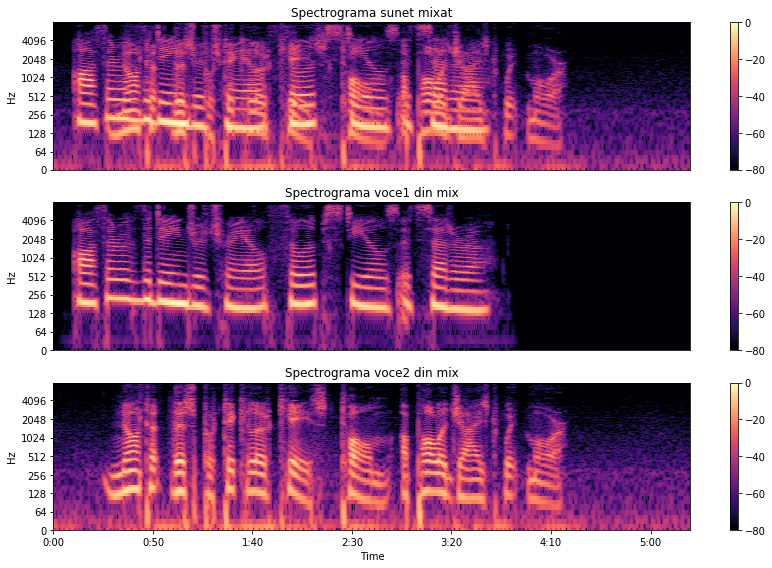

In [5]:
male_filename = 'recordings/male1/arctic_a0002.wav'
female_filename = 'recordings/female1/arctic_a0001.wav'

# for entire audio
female, male, mix = my_utils.load_and_mix_files(female_filename, male_filename)
split_entire_audio(female, male, mix)

#---------------------------------------
# split audio in segments
# mix is created inside function
# split_audio_using_small_segments(female_filename, male_filename)